# Training a semantic segmentation network

[Diego Ortego](https://sites.google.com/view/diegoortego/), [Insight Centre for Data Analytics](https://www.insight-centre.org/)

[Dublin City University](https://www.dcu.ie/)

---

This lab will illustrate how to specify and train a fully-convolutional neural networks for semantic segmentation. We will use a modified version of [PSPNet](https://arxiv.org/abs/1612.01105) architecture that consists of a backbone network (e.g. ResNet or VGG) with dilated convolutions in some layers, followed by a Pyramid Pooling Module to capture context information and the final convolutional classifier. Here, we will use a simplified version with ResNet-18 and a Pooling module (no pyramid) for faster training. We will use the [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset with lower resolution.


### Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

In [1]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


# Import packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_file_from_google_drive

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import sys
import argparse
import os
import time
from os.path import join
import csv

print('PyTorch version:', torch.__version__)

PyTorch version: 2.0.0+cu118


# Download dataset

In [3]:
!gdown --id 1Osg2LUhhx_utC1C2qTXcL5LBt4slN8Ll
#!gdown --id 1pQGv0etFunhM7uZrc1mU1ijTtnCbGpla

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Osg2LUhhx_utC1C2qTXcL5LBt4slN8Ll
To: /content/VOC2.tar
100% 3.35G/3.35G [01:32<00:00, 36.3MB/s]


In [4]:
!tar xf VOC2.tar

In [5]:
!rm VOC2.tar



```
# Tiene formato de código
```

# Hyperparameters + Enable GPU acceleration

In [14]:
class configuration:
    def __init__(self):
        self.experiment_name = "prueba_SemanticSegPreTrainedLR0.001"
        self.pre_load = "True" ## Load dataset in memory
        self.pre_trained = "True"
        self.num_classes = 21
        self.ignore_label = 255
        self.lr = 0.001  # 0.001 if pretrained. 0.1 if scratch
        self.M = [] ##If training from scratch, reduce learning rate at some point
        self.batch_size = 16  # Training batch size
        self.test_batch_size = 4  # Test batch size
        self.epoch = 30 ## Number of epochs
        # I decreased the number of epochs to 30 from 90 since the GPU was getting full and was getting timed out
        self.train_root = "./VOC"
        self.download = False
        self.seed = 271828


## Create arguments object
args = configuration()

# Make sure to enable GPU acceleration!
device = 'cuda'

# Set random seed for reproducability
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

## Define CNN architecture
We are using a modified PSPnet with a ResNet-18 backbone (pretrained on ImageNet or not). Note that there are no fully-connected layers in the networks, i.e. it is fully-convolutional.

In [15]:
class PSPNetLite(nn.Module):
    def __init__(self, args, num_classes, pretrained=True, use_aux=True):
        super(PSPNetLite, self).__init__()
        self.use_aux = use_aux
        
        #### TO FILL: define pytorch default resnet-18 architecture (pretrained and not) 
        if pretrained=="True":
            resnet = models.resnet18(pretrained=True)
        else:
            resnet = models.resnet18(pretrained=False)

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)

        ##Pooling module: simplification of Pyramid Pooling Module of PSPnet
        self.pm = nn.Sequential(
            nn.AdaptiveAvgPool2d(3),
            nn.Conv2d(512, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256, momentum=.95),
            nn.ReLU(inplace=True)
        )

        ## Final classifier to get per-pixel predictions
        self.final = nn.Sequential(
            nn.Conv2d(768, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=.95),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )
     
    #### To fill: write the forward pass function:
    #### layer0 --> layer1 --> layer2 --> layer3 --> layer4--> pm --> final
    def forward(self, x):
        x_size = x.size()

        x = self.layer0(x) #layer0
        x = self.layer1(x) #layer1
        x = self.layer2(x) #layer2
        x = self.layer3(x) #layer3
        
        x1 = self.layer4(x)
        x2 = self.pm(x1)

        # Concatenate layer4 features with upsampled Pooling Module features
        x = self.final(torch.cat((x1, F.interpolate(x2, x1.size()[2:], mode='bilinear')), dim=1))
        ##return prediction after bilinear upsampling to original size
        return F.interpolate(x, x_size[2:], mode='bilinear')

## Define dataset class
Dataset: [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) with over 8K (0.7K) images for training (validation). We use 224x224 resolution. Classes:

0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=diningtable,
12=dog, 13=horse, 14=motorbike, 15=person # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor


Method to make the dataset

In [16]:
def make_dataset(args, mode):
    assert mode in ['train', 'val', 'test']
    items = []
    if mode == 'train':
        img_path = os.path.join(args.train_root, 'benchmark_RELEASE', 'dataset', 'img')
        mask_path = os.path.join(args.train_root, 'benchmark_RELEASE', 'dataset', 'cls')
        data_list = [l.strip('\n') for l in open(os.path.join(
            args.train_root, 'benchmark_RELEASE', 'dataset', 'train.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.mat'))
            items.append(item)
    elif mode == 'val':
        img_path = os.path.join(args.train_root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        mask_path = os.path.join(args.train_root, 'VOCdevkit', 'VOC2012', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            args.train_root, 'VOCdevkit', 'VOC2012', 'ImageSets', 'Segmentation', 'seg11valid.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    else:
        img_path = os.path.join(args.train_root, 'VOCdevkit (test)', 'VOC2012', 'JPEGImages')
        data_list = [l.strip('\n') for l in open(os.path.join(
            args.train_root, 'VOCdevkit (test)', 'VOC2012', 'ImageSets', 'Segmentation', 'test.txt')).readlines()]
        for it in data_list:
            items.append((img_path, it))
    return items


class VOC(data.Dataset):
    def __init__(self, args, mode, transform_input=None, transform_mask=None):
        self.args = args
        self.imgs = make_dataset(self.args, mode)
        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        self.mode = mode

        self.transform_input = transform_input
        self.transform_mask = transform_mask

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(400, 400), interpolation=0)
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(224, 224))
        #### TO FILL: perform crops using random parameters from previous line.
        #### Note that crop parameters have to be the same for image and mask.
        #### If not, the ground-truth mask would not be aligned with its image content.
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        return image, mask

    def test_transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(400, 400), interpolation=0)
        image = resize(image)
        mask = resize(mask)

        # Random crop
        image = TF.center_crop(image, output_size=(224, 224))
        mask = TF.center_crop(mask, output_size=(224, 224))

        return image, mask

    def __getitem__(self, index):
        if self.mode == 'test':
            img_path, img_name = self.imgs[index]
            img = Image.open(os.path.join(img_path, img_name + '.jpg')).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            return img_name, img

        img_path, mask_path = self.imgs[index]
        img = Image.open(img_path).convert('RGB')
        if self.mode == 'train':
            mask = sio.loadmat(mask_path)['GTcls']['Segmentation'][0][0]
            mask = Image.fromarray(mask.astype(np.uint8))
        else:
            mask = Image.open(mask_path)

        ##Joint transform
        if self.mode=="train":
            img, mask = self.transform(img, mask)
        else:
            img, mask = self.test_transform(img, mask)

        if self.transform_input is not None:
            img = self.transform_input(img)
        if self.transform_mask is not None:
            mask = 255*self.transform_mask(mask)

        return img, mask.long()

    def __len__(self):
        return len(self.imgs)

# PSPnetLite training epoch
Per-pixel cross-entropy loss is computed and then aggregated to compute a loss per image.



In [17]:
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask].astype(int) +
        label_pred[mask], minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

def train_SemanticSeg(args, model, device, train_loader, optimizer, epoch):
    # switch to train mode
    model.train()

    train_loss = []
    counter = 1

    criterion = nn.CrossEntropyLoss()
    gts_all, predictions_all = [], []

    for batch_idx, (images, mask) in enumerate(train_loader):

        images, mask = images.to(device), mask.to(device)

        #Forward pass
        outputs = model(images)

        
        #Aggregated per-pixel loss
        loss = criterion(outputs, mask.squeeze(1))
        train_loss.append(loss.item())

        # compute gradient and do SGD step
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()

        
        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)), len(train_loader.dataset),
                100. * counter / len(train_loader), loss.item(),
                optimizer.param_groups[0]['lr']))
        counter = counter + 1
    
    return sum(train_loss) / len(train_loss)#, mean_iu

# PSPnetLite validation

In [18]:
def testing(args, model, device, test_loader):

    # switch to train mode
    model.eval()
    loss_per_batch = []
    test_loss = 0


    ##We ignore index 255, i.e. object contours labeled with 255 in the val GT
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    gts_all, predictions_all = [], []
    with torch.no_grad():
        for batch_idx, (images, mask) in enumerate(test_loader):

            images, mask = images.to(device), mask.to(device)

            outputs = model(images)

            #Aggregated per-pixel loss
            loss = criterion(outputs, mask.squeeze(1))
            loss_per_batch.append(loss.item())

            preds = outputs.data.max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
            gts_all.append(mask.data.squeeze(0).cpu().numpy())
            predictions_all.append(preds)

    #test_loss /= len(test_loader.dataset)
    loss_per_epoch = [np.average(loss_per_batch)]

    ##Compute Mean Intersection over Union (mIoU)
    ##mIoU: Mean (of all classes) of intersection over union between prediction
    ##and ground-truth
    hist = np.zeros((args.num_classes, args.num_classes))
    for lp, lt in zip(predictions_all, gts_all):
        hist += _fast_hist(lp.flatten(), lt.flatten(), args.num_classes)

    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    print('\nTest set ({:.0f}): Average loss: {:.4f}, mIoU: {:.4f}\n'.format(
        len(test_loader.dataset), loss_per_epoch[-1], mean_iu))

    return (loss_per_epoch, mean_iu)

# Image transformations

Here only simple transformations are shown. This code performs transformations by default inside the dataset class. The decision for doing this is to easily handle that transformations have to be applied similarly to the image and the ground-truth (GT) segmentation mask. For example, if a crop is done to the image in a certain location, it has to be done in the same location in the GT mask.

In [19]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


transform_input = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_mask = transforms.ToTensor()

# Dataset, network, optimizer and scheduler creation

In [20]:

trainset = VOC(args, 'train', transform_input=transform_input, transform_mask=transform_mask)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)
testset = VOC(args, 'val', transform_input=transform_input, transform_mask=transform_mask)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=8, pin_memory=True)

print('-------> Data loading')

model = PSPNetLite(args, num_classes=args.num_classes, pretrained=args.pre_trained).to(device)
print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

milestones = args.M
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

-------> Data loading
Total params: 15M


# Training loop

In [21]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch + 1):
    st = time.time()
    scheduler.step()
    # train for one epoch
    print("PSPnetLite training, epoch " + str(epoch))

    loss_per_epoch = train_SemanticSeg(args, model, device, train_loader, optimizer, epoch)

    loss_train_epoch += [loss_per_epoch]
    
    # test
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model, device, test_loader)

    loss_test_epoch += loss_per_epoch_test
    acc_test_per_epoch += [acc_val_per_epoch_i]


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i

    else:
        if acc_val_per_epoch_i > best_acc_val:
            best_acc_val = acc_val_per_epoch_i

    if epoch == args.epoch:
        torch.save(model.state_dict(), "mySemanticSegModelPreTrained.pth")
        #torch.save(model.state_dict(), "mySemanticSegModelScratch.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch))

    cont += 1

PSPnetLite training, epoch 1
Train Epoch: 1 [240/8498 (3%)]	Loss: 1.321014, Learning rate: 0.001000
Train Epoch: 1 [480/8498 (6%)]	Loss: 1.197029, Learning rate: 0.001000
Train Epoch: 1 [720/8498 (8%)]	Loss: 1.042855, Learning rate: 0.001000
Train Epoch: 1 [960/8498 (11%)]	Loss: 0.979825, Learning rate: 0.001000
Train Epoch: 1 [1200/8498 (14%)]	Loss: 0.729835, Learning rate: 0.001000
Train Epoch: 1 [1440/8498 (17%)]	Loss: 1.182990, Learning rate: 0.001000
Train Epoch: 1 [1680/8498 (20%)]	Loss: 0.969592, Learning rate: 0.001000
Train Epoch: 1 [1920/8498 (23%)]	Loss: 0.716654, Learning rate: 0.001000
Train Epoch: 1 [2160/8498 (25%)]	Loss: 0.851517, Learning rate: 0.001000
Train Epoch: 1 [2400/8498 (28%)]	Loss: 0.599831, Learning rate: 0.001000
Train Epoch: 1 [2640/8498 (31%)]	Loss: 0.812330, Learning rate: 0.001000
Train Epoch: 1 [2880/8498 (34%)]	Loss: 0.584725, Learning rate: 0.001000
Train Epoch: 1 [3120/8498 (37%)]	Loss: 0.615220, Learning rate: 0.001000
Train Epoch: 1 [3360/8498 (39

# Accuracy and loss curves

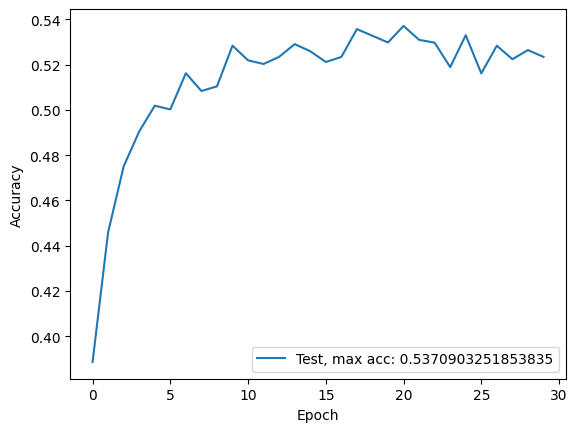

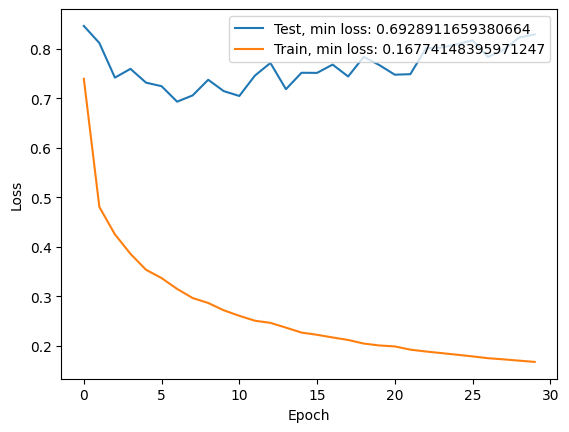

In [22]:
##Accuracy
acc_test = np.load(res_path + '/' + 'accuracy_per_epoch_val.npy')

#Loss per epoch
loss_train = np.load(res_path + '/' + 'LOSS_epoch_train.npy')
loss_test = np.load(res_path + '/' + 'LOSS_epoch_val.npy')

numEpochs = len(acc_test)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test, max acc: ' + str(np.max(acc_test)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train, min loss: ' + str(np.min(loss_train)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

# Visualize segmentation results
Do not expect great results.

In [23]:
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def visualizeSegmentation(args, model, device, test_loader, imageDenormalize, voc_palette):

    # switch to train mode
    model.eval()

    with torch.no_grad():
        for batch_idx, (images, mask) in enumerate(test_loader):

            images, mask = images.to(device), mask.to(device)

            outputs = model(images)

            plt.figure(batch_idx)

            for i in range(0, images.size(0)):


                image_np = (255*(imageDenormalize(images[i,...]).data.permute(1,2,0).cpu().numpy())).astype(np.uint8)
                gt_np = mask[i,...].squeeze().data.cpu().numpy()
                pred_np = outputs[i,...].data.max(0)[1].squeeze_(0).byte().cpu().numpy()

                img_pil = Image.fromarray(image_np)

                gt_np_color = np.stack((gt_np.copy(), gt_np.copy(), gt_np.copy()), axis=2)
                pred_np_color = np.stack((pred_np.copy(), pred_np.copy(), pred_np.copy()), axis=2)


                for j in range(0, 21):
                    idx_tuple = np.where(gt_np == j)
                    gt_np_color[idx_tuple[0], idx_tuple[1], 0] = colors[j][0]
                    gt_np_color[idx_tuple[0], idx_tuple[1], 1] = colors[j][1]
                    gt_np_color[idx_tuple[0], idx_tuple[1], 2] = colors[j][2]

                    idx_tuple2 = np.where(pred_np == j)
                    pred_np_color[idx_tuple2[0], idx_tuple2[1], 0] = colors[j][0]
                    pred_np_color[idx_tuple2[0], idx_tuple2[1], 1] = colors[j][1]
                    pred_np_color[idx_tuple2[0], idx_tuple2[1], 2] = colors[j][2]


                plt.subplot(args.test_batch_size, 3, i * 3 + 1)
                plt.imshow(img_pil)
                plt.subplot(args.test_batch_size, 3, i * 3 + 2)
                plt.imshow(gt_np_color)
                plt.subplot(args.test_batch_size, 3, i * 3 + 3)
                plt.imshow(pred_np_color)

                
            if batch_idx>7:
                plt.show()
                break


Total params: 15M


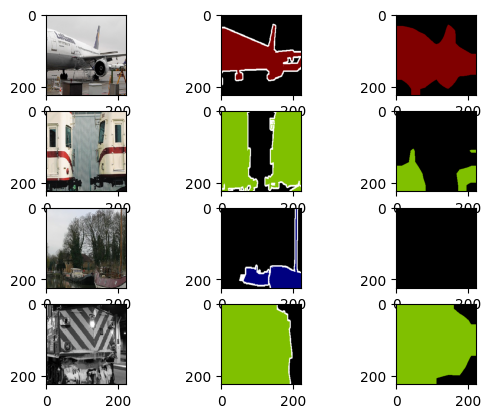

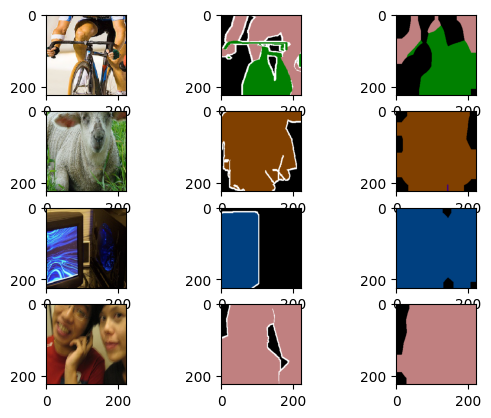

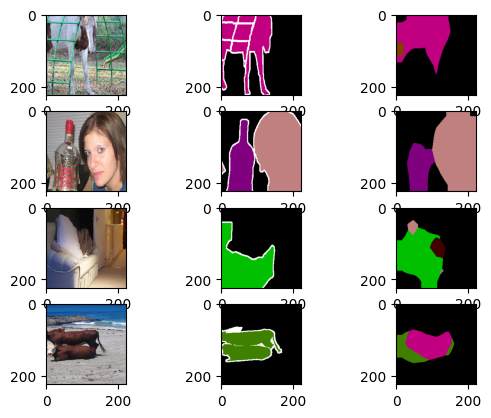

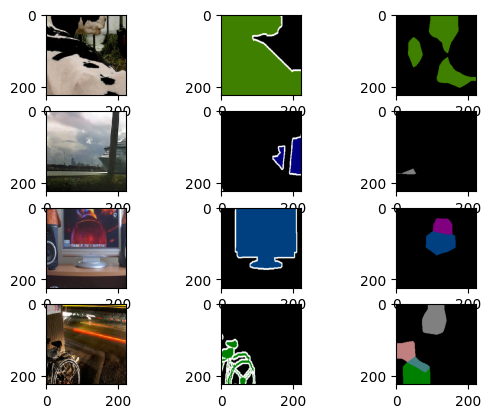

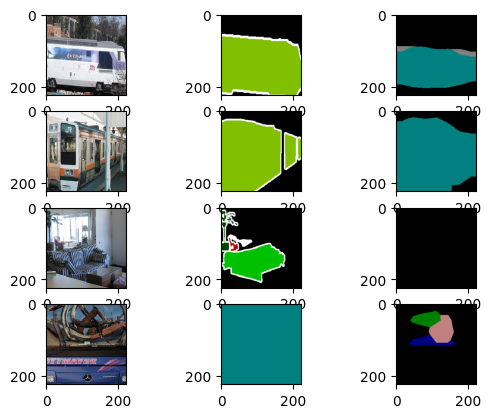

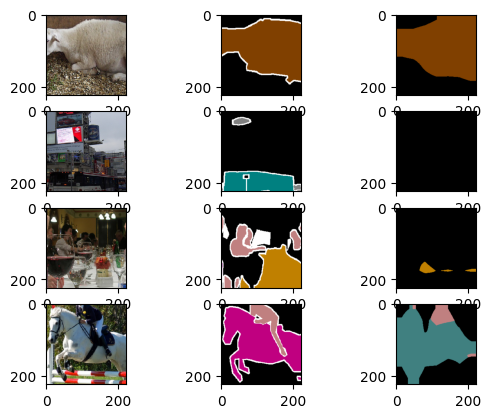

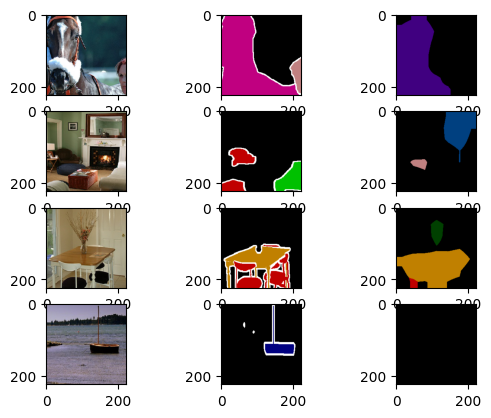

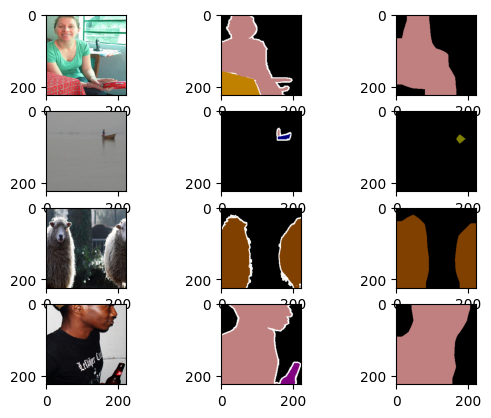

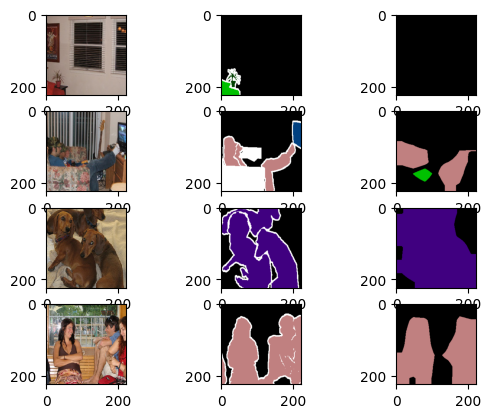

In [24]:
imageDenormalize = DeNormalize(mean,std)

## Color palette for visualization of the 21 classes
colors = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128],
            [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
            [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]])

model.load_state_dict(torch.load("mySemanticSegModelPreTrained.pth"))
#model.load_state_dict(torch.load("mySemanticSegModelScratch.pth"))

print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

cont = 0

visualizeSegmentation(args, model, device, test_loader, imageDenormalize, colors)